In [1]:
import os
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv(f'{os.getcwd()}/data/mean_tpm.csv', index_col=0)

In [3]:
# Log1p Transformation
# log1p_tpm_values = np.log1p(df['mean_tpm'])

# Min-Max Scaling
scaler = MinMaxScaler()
scaled_tpm_values = scaler.fit_transform(df['mean_tpm'].values.reshape(-1, 1))
df['mean_tpm'] = scaled_tpm_values

In [4]:
# One-hot encode species and stress_condition
enc_species = OneHotEncoder()
encoded_species = enc_species.fit_transform(df[['species']]).toarray()

enc_stress = OneHotEncoder()
encoded_stress_condition = enc_stress.fit_transform(df[['stress_condition']]).toarray()

# Function to one-hot encode DNA sequence
def one_hot_encode_sequence(sequence, max_length=200):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot_encoded = np.zeros((max_length, 4))
    for i, nucleotide in enumerate(sequence[:max_length]):
        if nucleotide in mapping:
            one_hot_encoded[i, mapping[nucleotide]] = 1
    return one_hot_encoded

# Apply one-hot encoding to the DNA sequences
max_length = df['upstream200'].apply(len).max()
sequences = df['upstream200'].apply(lambda seq: one_hot_encode_sequence(seq, max_length=max_length))
sequences = np.array(sequences.tolist())

# Convert to PyTorch tensors
sequence_tensor = torch.tensor(sequences, dtype=torch.float32).permute(0, 2, 1)
species_tensor = torch.tensor(encoded_species, dtype=torch.float32)
stress_tensor = torch.tensor(encoded_stress_condition, dtype=torch.float32)
y_tensor = torch.tensor(df['mean_tpm'].values, dtype=torch.float32).unsqueeze(1)

# Create dataset
dataset = TensorDataset(sequence_tensor, species_tensor, stress_tensor, y_tensor)

# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 1024 * 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
class DNA_CNN(nn.Module):
    def __init__(self, num_species, num_stress_conditions, max_length=203):
        super(DNA_CNN, self).__init__()
        self.max_length = max_length
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * (max_length // 2), 8)
        self.fc_species = nn.Linear(num_species, 8)
        self.fc_stress = nn.Linear(num_stress_conditions, 8)
        self.fc2 = nn.Linear(8 * 3, 1)  # 8 from CNN + 8 from species + 8 from stress

    def forward(self, x, species, stress):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 16 * (self.max_length // 2))
        x = torch.relu(self.fc1(x))

        species = torch.relu(self.fc_species(species))
        stress = torch.relu(self.fc_stress(stress))

        x = torch.cat((x, species, stress), dim=1)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [6]:
num_species = encoded_species.shape[1]
num_stress_conditions = encoded_stress_condition.shape[1]

model = DNA_CNN(num_species, num_stress_conditions, max_length=max_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [7]:
# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for step, (seqs, species, stress, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(seqs, species, stress)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        step_loss = loss.item() * seqs.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{step + 1}/{len(train_loader)}], Loss: {step_loss:.4f}')
        train_loss += step_loss
    
    train_loss /= len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for seqs, species, stress, targets in val_loader:
            outputs = model(seqs, species, stress)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * seqs.size(0)

    val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch [1/1], Step [1/4], Loss: 51837.6250
Epoch [1/1], Step [2/4], Loss: 505.1283
Epoch [1/1], Step [3/4], Loss: 2.7248
Epoch [1/1], Step [4/4], Loss: 0.7354
Epoch [1/1], Train Loss: 0.0583, Validation Loss: 0.0000


In [8]:
# Evaluation on test set
model.eval()
test_loss = 0.0
predictions, ground_truth = [], []
with torch.no_grad():
    for seqs, species, stress, targets in test_loader:
        outputs = model(seqs, species, stress)
        predictions.append(outputs)
        ground_truth.append(targets)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * seqs.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0000


In [9]:
predictions = torch.cat(predictions, axis=0)
ground_truth = torch.cat(ground_truth, axis=0)
output_df = pd.DataFrame({'actual': ground_truth.flatten(), 'predicted': predictions.flatten()})

### Scatter Plot

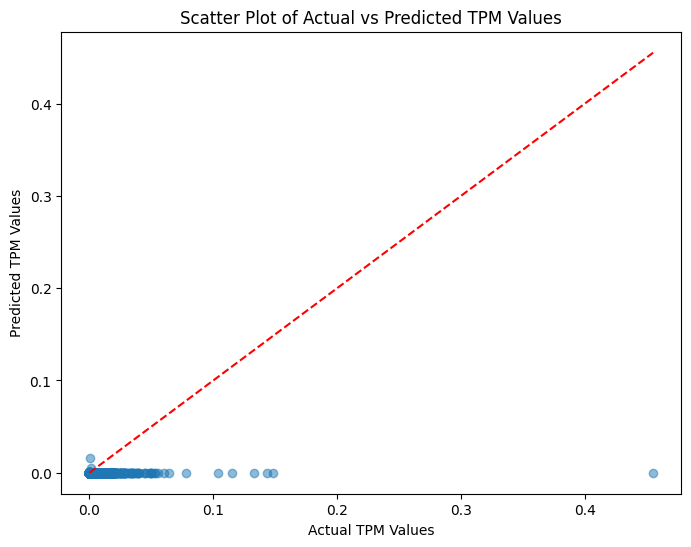

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(output_df['actual'], output_df['predicted'], alpha=0.5)
plt.plot([output_df['actual'].min(), output_df['actual'].max()], [output_df['actual'].min(), output_df['actual'].max()], 'r--')
plt.xlabel('Actual TPM Values')
plt.ylabel('Predicted TPM Values')
plt.title('Scatter Plot of Actual vs Predicted TPM Values')
plt.show()

### Residual Plot

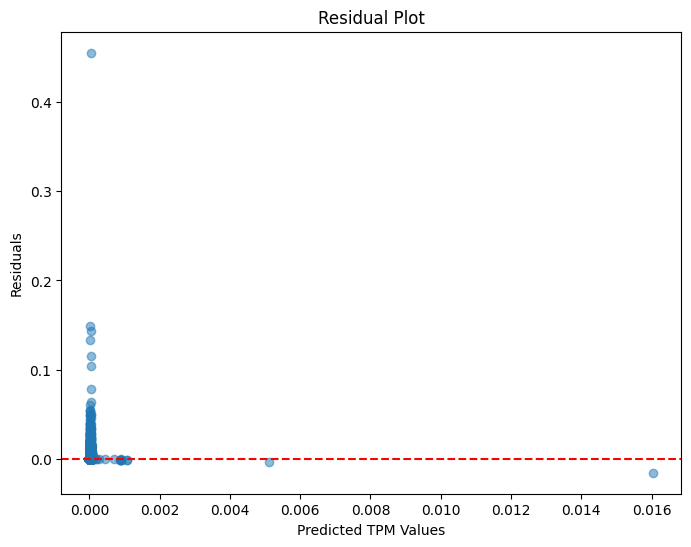

In [11]:
output_df['residuals'] = output_df['actual'] - output_df['predicted']

plt.figure(figsize=(8, 6))
plt.scatter(output_df['predicted'], output_df['residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted TPM Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Distribution Plot

/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_52333/2412845803.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(output_df['actual'], label='Actual', shade=True)
/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_52333/2412845803.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(output_df['predicted'], label='Predicted', shade=True)


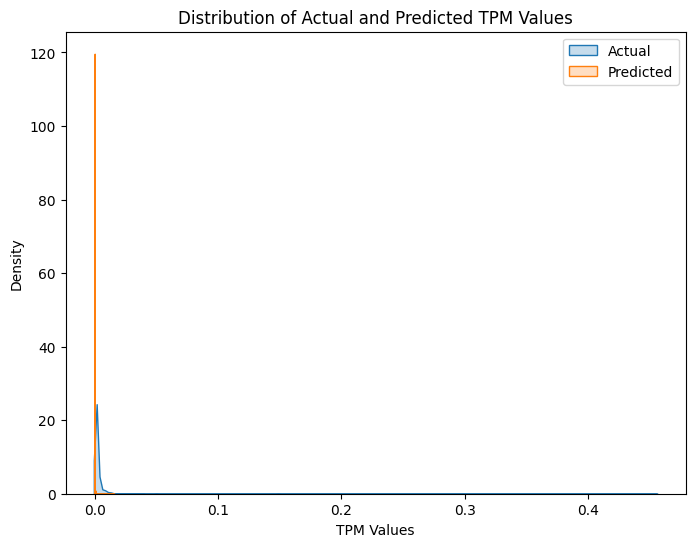

In [12]:
plt.figure(figsize=(8, 6))
sns.kdeplot(output_df['actual'], label='Actual', shade=True)
sns.kdeplot(output_df['predicted'], label='Predicted', shade=True)
plt.xlabel('TPM Values')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted TPM Values')
plt.legend()
plt.show()

### Box Plot

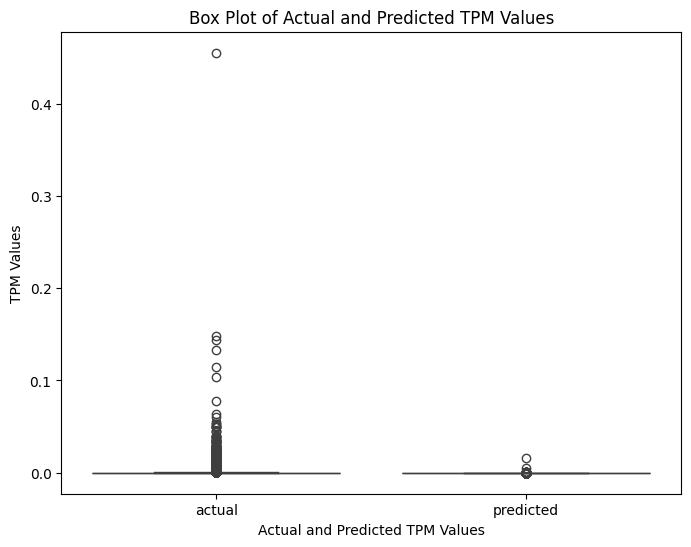

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=output_df[['actual', 'predicted']])
plt.xlabel('Actual and Predicted TPM Values')
plt.ylabel('TPM Values')
plt.title('Box Plot of Actual and Predicted TPM Values')
plt.show()

### Parity Plot

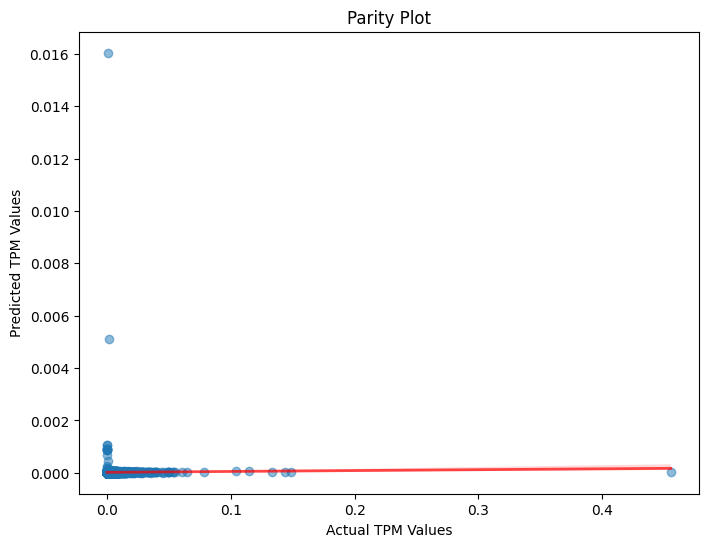

In [14]:
plt.figure(figsize=(8, 6))
sns.regplot(x='actual', y='predicted', data=output_df, scatter_kws={'alpha':0.5}, line_kws={"color":"r","alpha":0.7,"lw":2})
plt.xlabel('Actual TPM Values')
plt.ylabel('Predicted TPM Values')
plt.title('Parity Plot')
plt.show()

### Cumulative Density Function (CDF) Plot

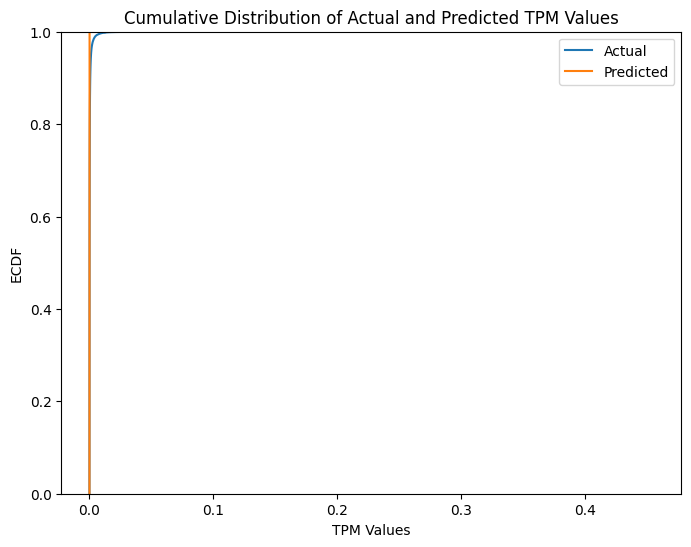

In [15]:
plt.figure(figsize=(8, 6))
sns.ecdfplot(output_df['actual'], label='Actual')
sns.ecdfplot(output_df['predicted'], label='Predicted')
plt.xlabel('TPM Values')
plt.ylabel('ECDF')
plt.title('Cumulative Distribution of Actual and Predicted TPM Values')
plt.legend()
plt.show()